# **Analysis of Dams in NSW**
---

## **Introduction**
I sourced data from the Water Insights API, provided by WaterNSW — a state-owned corporation responsible for capturing, storing, and delivering raw water from New South Wales’ dams and rivers to support communities, agriculture, industry, and the environment.
This analysis explores dam performance across NSW by addressing three core questions on location, operational metrics, and seasonal trends as follows:
- Where are dams located across NSW?
    - My assumption: mostly near major cities ( e.g. Sydney) and the coast and reduce the further inland you go.
- What operational metrics are tracked for each dam?
- What is the current operational status of NSW dams, and how has it trended over the past year?
    - Aimed to assess for seasonal trends, variability, and potential risks.

In [1]:
import requests                                                                   # Imports the requests library to handle HTTP requests
import base64                                                                     # Imports base64 for encoding credentials securely

# Read credentials from file
creds = {}
with open("credentials.txt", "r") as f:
    for line in f:
        key, value = line.strip().split("=")
        creds[key] = value

# Encode credentials
credentials = f"{creds['api_key']}:{creds['api_secret']}"                         # Combines API key and API secret in 'key:secret' format
encoded_credentials = base64.b64encode(credentials.encode()).decode()

# Request access token
token_url = "https://api.onegov.nsw.gov.au/oauth/client_credential/accesstoken"   # OAuth token endpoint
headers = {
    "Authorization": f"Basic {encoded_credentials}"                               # Sets the Authorisation header using encoded credentials
}
params = {
    "grant_type": "client_credentials"                                            # Specifies the OAuth grant type
}

response = requests.get(token_url, headers=headers, params=params)                # Sends GET request to fetch access token
access_token = response.json().get("access_token")                                # Extracts the access token from the JSON response

In [2]:
import pandas as pd

# Load credentials from file
creds = {}
with open("credentials.txt", "r") as f:
    for line in f:
        key, value = line.strip().split("=")
        creds[key] = value

# Assign variables
api_key = creds["api_key"]
api_secret = creds["api_secret"]

# Define headers for the API request
headers = {
    "Authorization": f"Bearer {access_token}",                             # Adds the OAuth access token for authentication
    "apikey": api_key                                                      # Includes the API key for additional verification
}

main_url = "https://api.onegov.nsw.gov.au/waternsw-waterinsights/v1/dams"  # Define the endpoint URL for retrieving dam metadata
response = requests.get(main_url, headers=headers)                         # Send a GET request to the API using the headers
main_data = response.json()                                                # Parse the JSON response into a Python dictionary

df_main = pd.json_normalize(main_data['dams'])                             # Normalise the nested 'dams' JSON structure into a flat pandas DataFrame

 - The code uses OAuth 2.0 client credentials to authenticate with the WaterNSW API, retrieve dam data, and convert the JSON response into a structured pandas DataFrame for analysis.

In [3]:
# Display the first 5 rows of the DataFrame for quick inspection of its structure and contents
print(df_main.head())

   dam_id            dam_name  full_volume        lat        long  \
0  203042       Toonumbar Dam        10814 -28.602383  152.763769   
1  210097        Glenbawn Dam       748827 -32.064304  150.982007   
2  210102         Lostock Dam        19736 -32.335999  151.440793   
3  210117  Glennies Creek Dam       282303 -32.339259  151.286947   
4  212205          Nepean Dam        67730 -34.335046  150.617666   

                                              _links  
0  [{'href': 'https://api.onegov.nsw.gov.au/water...  
1  [{'href': 'https://api.onegov.nsw.gov.au/water...  
2  [{'href': 'https://api.onegov.nsw.gov.au/water...  
3  [{'href': 'https://api.onegov.nsw.gov.au/water...  
4  [{'href': 'https://api.onegov.nsw.gov.au/water...  


- The data from the main API only contained 6 columns with basic dam information, lacking sufficient detail for analysis
- The final column, _links, includes a list of API URLs pointing to additional dam-specific data
- The below code was used to fetch and merge this extended data from each URL into a final combined dataframe for this analysis

In [4]:
# Defines a function to build a resource URL for a given date range
def build_resource_url(links, from_date, to_date):
    for link in links:                                                      # Loop through each link dictionary in the list
        if link['rel'] == 'related':                                        # Check if link is marked as 'related' & contains word 'latest' in its URL
            return f"{link['href']}?to={to_date}&from={from_date}"          # Construct and return the full URL with the specified date range appended
    return None                                                             # If no matching link is found, return None

In [5]:
import time                                                                # Imports the time module to pace API requests

# Defines a function to fetch the latest resource data from a given URL
def fetch_resource_data(url):                                               # Check if the URL is empty or None (e.g., no 'related' link found)
    if not url:
        return {}                                                           # Return an empty dictionary to indicate no data to fetch
    time.sleep(4)                                                           # Pause for 4 seconds to avoid overwhelming the API 
    res = requests.get(url, headers=headers)                                # Send a GET request to the provided resource URL using the authentication headers
    if res.status_code != 200:                                              # Check if the response status code is not 200 (i.e., request failed)
        print(f"Failed to fetch: {url} — Status code: {res.status_code}")   # Log the failed URL and status
        print("Raw response:", res.text)                                    # Print the raw response for debugging
        return {}                                                           # Return an empty dictionary to gracefully handle failure
    try:                                                                    # Attempt to parse the JSON and extract the first resource entry for the dam
        return res.json()['dams'][0]['resources'][0]
    except Exception as e:                                                  # If parsing fails (e.g., missing keys, malformed JSON), log the error
        print(f"Error parsing JSON from: {url} — {e}")
        return {}                                                           # Return an empty dictionary to avoid crashing the pipeline

In [6]:
# Defines a dictionary of named date ranges for monthly data pulls
# Each key is a label (e.g. 'March-April'), and each value is a tuple of (from_date, to_date)

date_ranges = {
    'Dec-Jan':   ('2024-12-01', '2025-01-09'),
    'Jan-Feb': ('2025-01-02', '2025-02-09'),
    'Feb-March': ('2025-02-02', '2025-03-09'),
    'March-April':   ('2025-03-01', '2025-04-09'),
    'April-May': ('2025-04-02', '2025-05-09'),
    'May-June': ('2025-05-02', '2025-06-09'),
    'June-July':   ('2025-06-01', '2025-07-09'),
    'July-August': ('2025-07-02', '2025-08-09'),
    'August-Sept': ('2025-08-02', '2025-09-09')
}

monthly_dfs = []                                                            # Initialises an empty list to store DataFrames for each month's combined data
                                                                            # Loop through each entry in the date_ranges dictionary
for label, (from_date, to_date) in date_ranges.items():                     # 'label' is range (e.g.'March-April') & (from_date, to_date) date boundaries
    print(f"\n🔄 Fetching data for: {label}")                              # Print status message indicating which date range is currently being processed

    
# For each dam in df_main, apply the build_resource_url function to its '_links' field
# This generates a new column with the full resource URL for the current date range
# Column name dynamically created using the label (e.g. 'resource_url_March-April')
    df_main[f'resource_url_{label}'] = df_main['_links'].apply(
        lambda links: build_resource_url(links, from_date, to_date)
    )

# Applies the fetch_resource_data function to each dam's resource URL for the current date range
# df_main[f'resource_url_{label}'] accesses the column containing resource URLs for this specific month (e.g. 'resource_url_July-August')
# .apply(fetch_resource_data) calls the function on each URL in that column
# The result is a Series of dictionaries, where each dictionary contains the fetched resource data for one dam
    resource_data = df_main[f'resource_url_{label}'].apply(fetch_resource_data)

# Creates a new DataFrame to hold structured resource data & converts the Series of dictionaries (resource_data) into a list of dictionaries  
# This ensures each dictionary becomes a row in the resulting DataFrame 
    df_resources = pd.DataFrame(resource_data.tolist())                                                                     

# Combining the DataFrames into one & removes unnecessary columns from df_main before merging
# Add the resource data, already structured as a DataFrame & concatenates along columns - side-by-side merge
    df_combined_month = pd.concat([
        df_main.drop(columns=['_links'] + [col for col in df_main.columns if col.startswith('resource_url_')]),
        df_resources
    ], axis=1)

    df_combined_month['month_range'] = label                               # Add a column to tag the month

    monthly_dfs.append(df_combined_month)                                  # Store for final merge

df_combined = pd.concat(monthly_dfs, ignore_index=True)                    # Concatenate all monthly DataFrames into one


🔄 Fetching data for: Dec-Jan
Failed to fetch: https://api.onegov.nsw.gov.au/waternsw-waterinsights/v1/dams/BlueMountainsTotal/resources?to=2025-01-09&from=2024-12-01 — Status code: 422
Raw response: {"status":"error","statusCode":422,"message":"Internal Server Error"}

🔄 Fetching data for: Jan-Feb
Failed to fetch: https://api.onegov.nsw.gov.au/waternsw-waterinsights/v1/dams/BlueMountainsTotal/resources?to=2025-02-09&from=2025-01-02 — Status code: 422
Raw response: {"status":"error","statusCode":422,"message":"Internal Server Error"}

🔄 Fetching data for: Feb-March
Failed to fetch: https://api.onegov.nsw.gov.au/waternsw-waterinsights/v1/dams/BlueMountainsTotal/resources?to=2025-03-09&from=2025-02-02 — Status code: 422
Raw response: {"status":"error","statusCode":422,"message":"Internal Server Error"}

🔄 Fetching data for: March-April
Failed to fetch: https://api.onegov.nsw.gov.au/waternsw-waterinsights/v1/dams/BlueMountainsTotal/resources?to=2025-04-09&from=2025-03-01 — Status code: 42

- Error handling also revealed dam_id BlueMountainsTotal consistently returned a HTTP 422 (Unprocessable Entity) error across all date ranges, suggesting a persistent issue with the request or endpoint

In [7]:
# Display first 5 rows of the combined DataFrame for review
print(df_combined.head())

   dam_id            dam_name  full_volume        lat        long        date  \
0  203042       Toonumbar Dam        10814 -28.602383  152.763769  2025-01-01   
1  210097        Glenbawn Dam       748827 -32.064304  150.982007  2025-01-01   
2  210102         Lostock Dam        19736 -32.335999  151.440793  2025-01-01   
3  210117  Glennies Creek Dam       282303 -32.339259  151.286947  2025-01-01   
4  212205          Nepean Dam        67730 -34.335046  150.617666  2025-01-01   

   storage_volume  percentage_full  storage_inflow  storage_release  \
0         10863.0           100.45          5762.0           5762.0   
1        723844.0            96.66         19651.0           3533.0   
2         19905.0           100.86         43638.0          42839.0   
3        280054.0            99.20         16524.0           1751.0   
4         59498.0            87.85             0.0              0.0   

  month_range  
0     Dec-Jan  
1     Dec-Jan  
2     Dec-Jan  
3     Dec-Jan  
4     

- Data retrieval process successfully completed, confirming access to the extended resource data
- With the additional data now available, analysis can proceed as intended

In [8]:
# Check for any rows with missing data
df_combined[df_combined.isna().any(axis=1)]

,dam_id,dam_name,full_volume,lat,long,date,storage_volume,percentage_full,storage_inflow,storage_release,month_range
37,BlueMountainsTotal,Blue Mountains Dams,2890,-33.693311,150.298807,NaN,NaN,NaN,NaN,NaN,Dec-Jan
75,BlueMountainsTotal,Blue Mountains Dams,2890,-33.693311,150.298807,NaN,NaN,NaN,NaN,NaN,Jan-Feb
113,BlueMountainsTotal,Blue Mountains Dams,2890,-33.693311,150.298807,NaN,NaN,NaN,NaN,NaN,Feb-March
151,BlueMountainsTotal,Blue Mountains Dams,2890,-33.693311,150.298807,NaN,NaN,NaN,NaN,NaN,March-April
189,BlueMountainsTotal,Blue Mountains Dams,2890,-33.693311,150.298807,NaN,NaN,NaN,NaN,NaN,April-May
227,BlueMountainsTotal,Blue Mountains Dams,2890,-33.693311,150.298807,NaN,NaN,NaN,NaN,NaN,May-June
265,BlueMountainsTotal,Blue Mountains Dams,2890,-33.693311,150.298807,NaN,NaN,NaN,NaN,NaN,June-July
303,BlueMountainsTotal,Blue Mountains Dams,2890,-33.693311,150.298807,NaN,NaN,NaN,NaN,NaN,July-August
341,BlueMountainsTotal,Blue Mountains Dams,2890,-33.693311,150.298807,NaN,NaN,NaN,NaN,NaN,August-Sept


| Column Name       | Description                  |
|:------------------|:-----------------------------|
| full_volume       | Maximum capacity of each dam |
| storage_volume    | Current water volume         |
| percentage_full   | How full each dam is         |
| storage_inflow    | Water entering the dam       |
| storage_release   | Water being released         |

- A check for missing data identified 9 affected rows which were missing key data required for analysis
- All missing entries linked to the dam ID that generated API call errors: BlueMountainsTotal

In [9]:
print(df_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dam_id           342 non-null    object 
 1   dam_name         342 non-null    object 
 2   full_volume      342 non-null    int64  
 3   lat              342 non-null    float64
 4   long             342 non-null    float64
 5   date             333 non-null    object 
 6   storage_volume   333 non-null    float64
 7   percentage_full  333 non-null    float64
 8   storage_inflow   333 non-null    float64
 9   storage_release  333 non-null    float64
 10  month_range      342 non-null    object 
dtypes: float64(6), int64(1), object(4)
memory usage: 29.5+ KB
None


- The combined dataset contains 342 entries across 11 columns
- Data types include float64 (6 columns) and object (5 columns)
- Columns cover dam metadata, date, and monthly metrics (volume, percentage full, inflow, outflow)

In [10]:
# Droping of the specific missing data impacted rows
df_combined = df_combined.drop([37,75,113,151,189,227,265,303,341])

- These rows were removed from the dataset to maintain analytical integrity
- The removed rows represented approximately 2.6% of the total data, a proportion which I deemed acceptable

In [11]:
# Check for any rows with missing data - counts rows with at least one NaN
null_row_count = df_combined[df_combined.isna().any(axis=1)].shape[0]
print(f"Number of rows with missing values: {null_row_count}")

Number of rows with missing values: 0


In [12]:
# Disply dataframe information
print(df_combined.info())

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 340
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dam_id           333 non-null    object 
 1   dam_name         333 non-null    object 
 2   full_volume      333 non-null    int64  
 3   lat              333 non-null    float64
 4   long             333 non-null    float64
 5   date             333 non-null    object 
 6   storage_volume   333 non-null    float64
 7   percentage_full  333 non-null    float64
 8   storage_inflow   333 non-null    float64
 9   storage_release  333 non-null    float64
 10  month_range      333 non-null    object 
dtypes: float64(6), int64(1), object(4)
memory usage: 31.2+ KB
None


- Updated successfully, reducing  total row count from 342 to 333 with the removal of incomplete entries - dataset is now clean and analysis-ready

## **Analysing The Data**

In [13]:
# Generate summary statistics for all numeric columns in the DataFrame
df_combined.describe()

,full_volume,lat,long,storage_volume,percentage_full,storage_inflow,storage_release
count,3.330000e+02,333.000000,333.000000,3.330000e+02,333.000000,333.000000,333.000000
mean,4.485471e+05,-33.180225,148.773611,2.930919e+05,80.098529,14416.827622,10002.057057
std,6.613299e+05,1.836625,3.109421,4.237148e+05,23.239350,51628.399081,27625.287697
min,2.700000e+03,-36.570300,142.229739,4.670000e+02,7.690000,-10419.000000,0.000000
25%,3.333000e+04,-34.336403,148.254929,2.886100e+04,61.850000,0.000000,0.000000
50%,1.157590e+05,-33.492387,150.315266,9.457200e+04,89.390000,0.000000,0.000000
75%,6.294920e+05,-32.300000,150.803553,3.953350e+05,99.950000,6779.300000,4646.000000
max,2.982000e+06,-28.602383,152.763769,2.064680e+06,112.660000,757987.000000,249084.000000


### **Observation From Descriptive Statistics**
- The mean fill level (percentage full) across dams over the 9-month period (Dec–Aug) was 80.1%
- The median fill level was 89.4%, the mean is lower than the median indicating a left-skewed distribution
- The maximum recorded fill level was 112.66%, exceeding nominal capacity
- The minimum recorded fill level was 7.69%, indicating very low storage in at least one dam
- The range between maximum and minimum fill levels reflects substantial variability in dam utilisation across NSW
- 50% of dams recorded zero inflow and zero release during the period
- The maximum inflow observed was 757,987 ML
- The minimum release recorded was 249,084 ML
- A negative inflow value of –10,419 ML was present in the dataset

*Megalitres (ML) equals 1 million litres:*
- *One ML is roughly half the volume of an Olympic pool (which holds about 2.5 ML)*
- *The average Australian household uses about 0.2 ML per year so 1 ML could supply five households for a year*

In [14]:
# Filter for dams with negative inflow values, sort by inflow ascending, and display the top 5 cases with relevant context columns

df_combined[df_combined['storage_inflow'] < 0] \
    .sort_values(by='storage_inflow') \
    [['dam_name', 'month_range', 'percentage_full', 'storage_inflow', 'storage_release']] \
    .head(5)

,dam_name,month_range,percentage_full,storage_inflow,storage_release
95,Lake Wyangala,Feb-March,81.92,-10419.0,38803.0
19,Lake Wyangala,Dec-Jan,87.04,-7965.0,64702.0
133,Lake Wyangala,March-April,79.79,-5431.0,19799.0
104,Burrendong Dam,Feb-March,51.35,-4351.0,26859.0
105,Windamere Dam,Feb-March,89.74,-661.0,1499.5


To investigate the Min negative inflow value above the above filtering was performed;  
- Multiple dams recorded negative minimum values for storage_inflow
- The issue was not isolated, reducing the likelihood of a single-point data error
- The pattern suggests potential causes such as evaporation misclassification or reverse flow dynamics

### **Latest Dam Storage Levels**

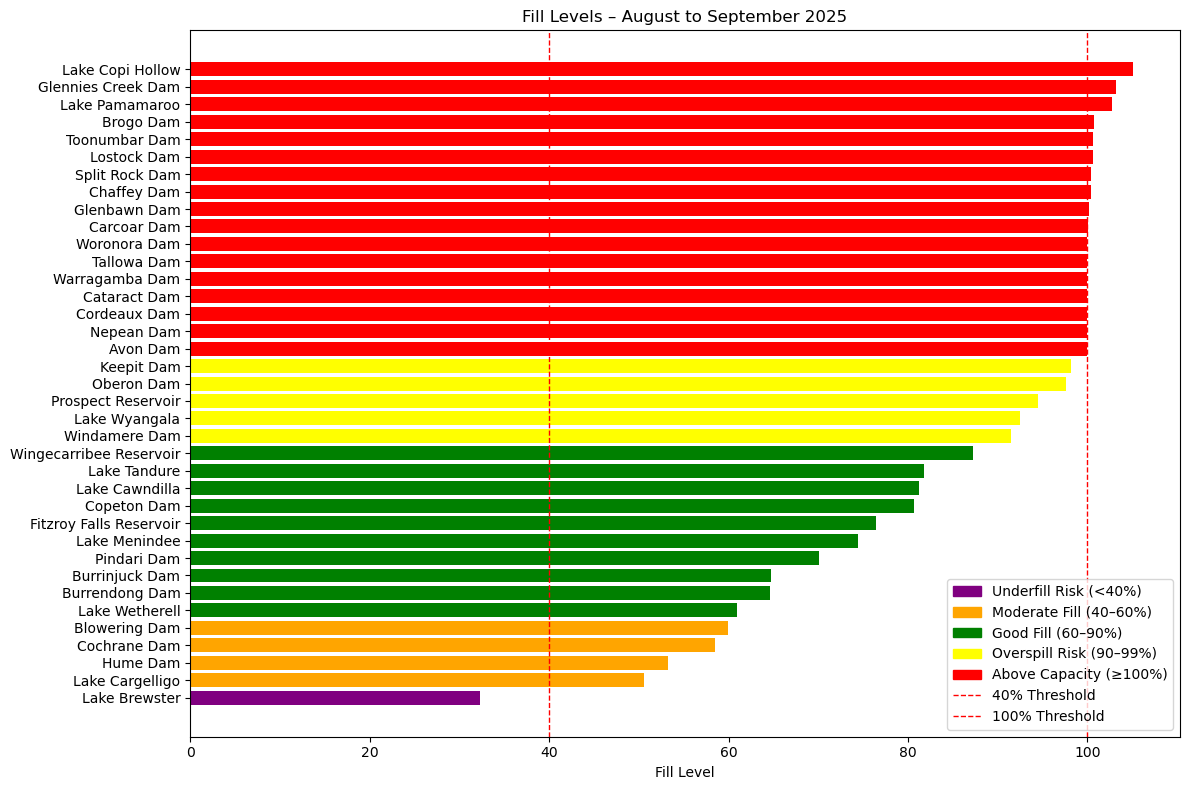

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Filter for the latest monthly data
df_plot = df_combined[
    (df_combined['date'] == '2025-09-01') | 
    (df_combined['month_range'] == 'August-Sept')
]

# Sorting by Fill Level
df_plot = df_plot.sort_values(by='percentage_full', ascending=True)

# Assign colors based on fill level thresholds
colors = df_plot['percentage_full'].apply(
    lambda x: 'purple' if x < 40 else
              'orange' if x < 60 else
              'green' if x < 90 else
              'yellow' if x < 100 else
              'red'
).tolist()

# Create proxy artists for the legend
legend_patches = [
    mpatches.Patch(color='purple', label='Underfill Risk (<40%)'),
    mpatches.Patch(color='orange', label='Moderate Fill (40–60%)'),
    mpatches.Patch(color='green', label='Good Fill (60–90%)'),
    mpatches.Patch(color='yellow', label='Overspill Risk (90–99%)'),
    mpatches.Patch(color='red', label='Above Capacity (≥100%)')
]

# Create horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(df_plot['dam_name'], df_plot['percentage_full'], color=colors)
plt.xlabel('Fill Level')
plt.title('Fill Levels – August to September 2025')

# Threshold lines
plt.axvline(40, color='red', linestyle='--', linewidth=1, label='40% Threshold')
plt.axvline(100, color='red', linestyle='--', linewidth=1, label='100% Threshold')

# Combine threshold and color legends
plt.legend(handles=legend_patches + plt.gca().get_legend_handles_labels()[0], loc='lower right')

plt.tight_layout()
plt.show()

**August Fill Level Distribution — Observations**
- 46% of dams were Above Capacity range
- 13% of dams were in the Overspill range
- 27% of dams fell within Good Fill range
- 11% of dams were in the Moderate Fill range
- 3% of dams were in the Underfill Risk range

### **Dam Locations**

In [16]:
import folium

# Filter for the latest monthly data
df_latest = df_combined[
    (df_combined['date'] == '2025-09-01') | 
    (df_combined['month_range'] == 'August-Sept')
]

# Create base map centered over NSW
dam_map = folium.Map(location=[-33.5, 151], zoom_start=6)

# Define color mapping based on percentage full
def get_color(pct):
    if pct < 40:
        return 'purple'
    elif pct >= 40 and pct < 60:
        return 'orange'
    elif pct > 90 and pct < 100:
        return 'yellow'
    elif pct >= 100:
        return 'red'
    else:
        return 'green'

# Define radius scaling based on percentage full
def scale_radius(pct):
    # Clamp values between 0 and 120, then scale to a radius between 3 and 10
    pct = max(0, min(pct, 120))
    return 3 + (pct / 120) * 7  # 3 base + up to 7 extra

# Add circle markers for each dam in the filtered dataset
for _, row in df_latest.iterrows():
    lat = row['lat']
    lon = row['long']
    name = row['dam_name']
    pct = row['percentage_full']
    color = get_color(pct)
    radius = scale_radius(pct)

    folium.CircleMarker(
        location=[lat, lon],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=f"{name} — {pct:.1f}% full"
    ).add_to(dam_map)

# Display the map
display(dam_map)

- Map displays dam locations across New South Wales
- Utilised fill level data as an indicator using the same color-coded markers as the above bar graph
- Marker radius also tied to fill level to help indicate overfill and underfill statuses   
- Higher concentration of dams observed near Sydney and the eastern coast
- Inland dam locations exhibit lower percentage full values
- Spatial distribution suggests geographic variation in dam performance

### **Monthly Trends**

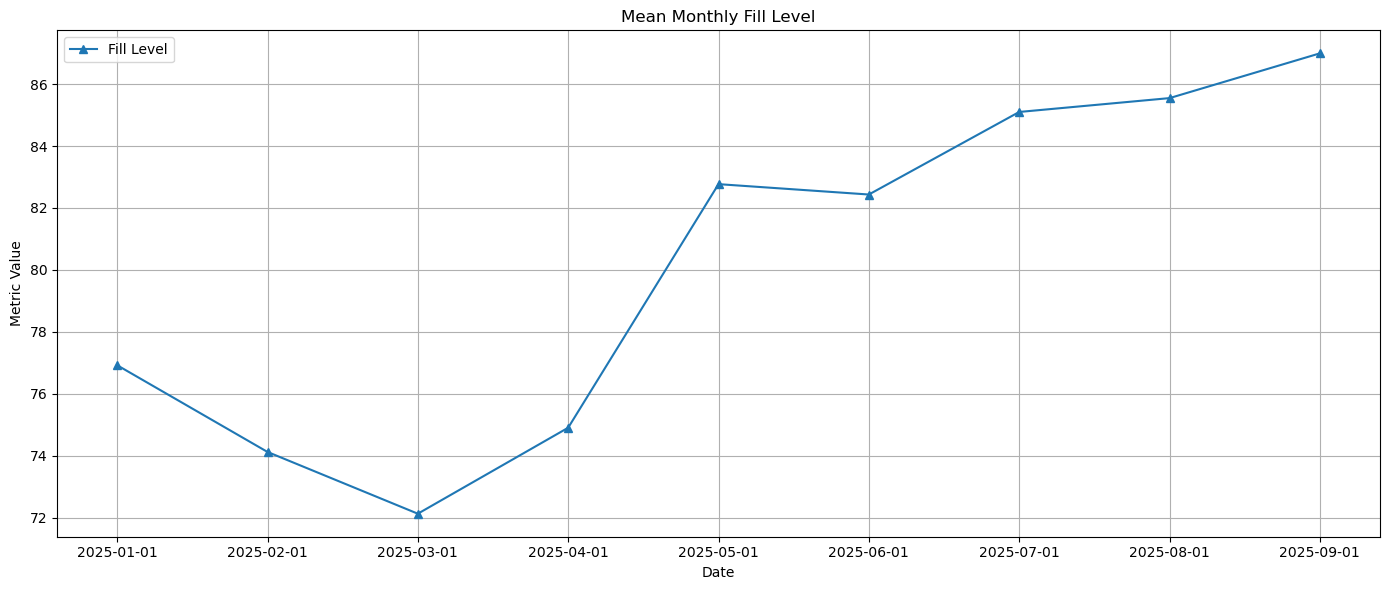

In [17]:
# Group by date and calculate mean 
monthly_stats = df_combined.groupby('date').agg({
    'percentage_full': 'mean'
}).reset_index()

# Plot trends
plt.figure(figsize=(14, 6))

plt.plot(monthly_stats['date'], monthly_stats['percentage_full'], marker='^', label='Fill Level')

plt.title('Mean Monthly Fill Level')
plt.xlabel('Date')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Mean monthly dam fill levels declined from Jan to March 2025, then steadily increased through August before a slight dip in September

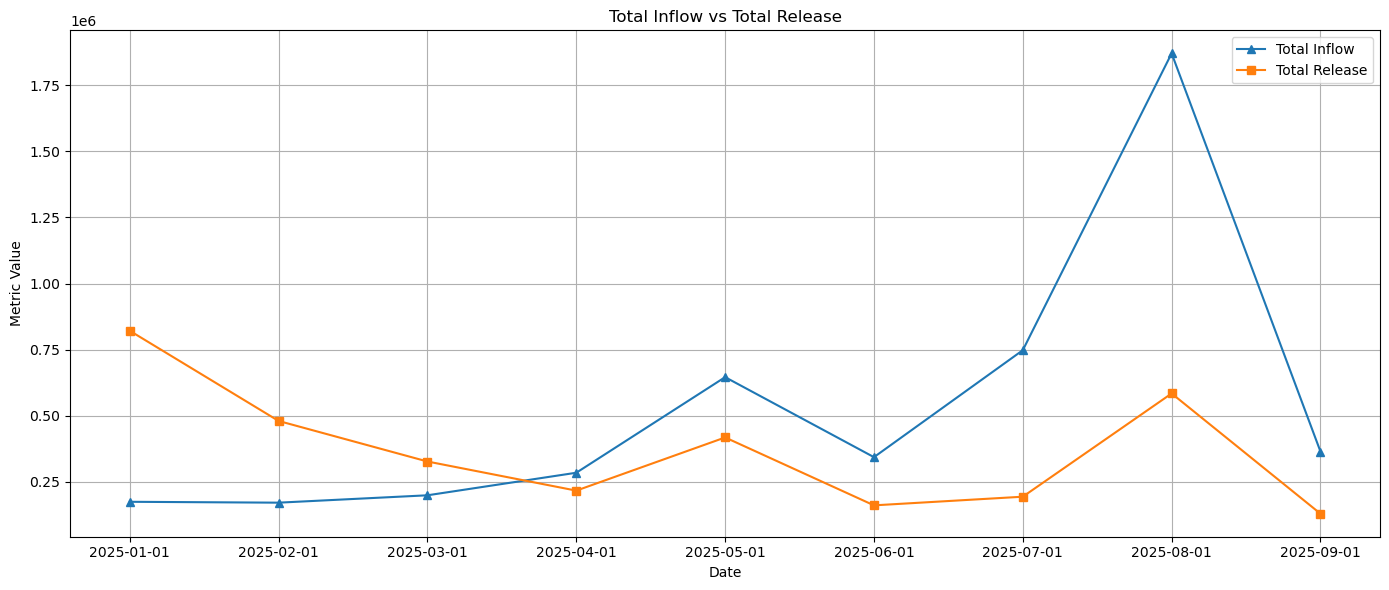

In [18]:
# Group by date and calculate mean or median
monthly_stats = df_combined.groupby('date').agg({
    'storage_inflow': 'sum',
    'storage_release': 'sum'
}).reset_index()

# Plot trends
plt.figure(figsize=(14, 6))

plt.plot(monthly_stats['date'], monthly_stats['storage_inflow'], marker='^', label='Total Inflow')
plt.plot(monthly_stats['date'], monthly_stats['storage_release'], marker='s', label='Total Release')

plt.title('Total Inflow vs Total Release')
plt.xlabel('Date')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- From January to March 2025, release exceeded inflow, indicating net outflow during early months
- From April onward, inflow consistently surpassed release, peaking sharply in August before both declined in September

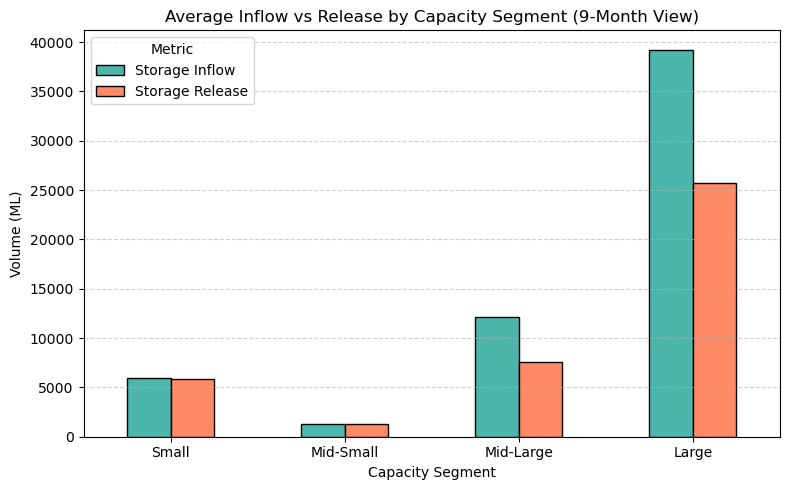

In [19]:
# Ensure numeric types
df_combined['full_volume'] = pd.to_numeric(df_combined['full_volume'], errors='coerce')
df_combined['storage_inflow'] = pd.to_numeric(df_combined['storage_inflow'], errors='coerce')
df_combined['storage_release'] = pd.to_numeric(df_combined['storage_release'], errors='coerce')

# Create capacity segments using quartiles
df_combined['size_segment'] = pd.qcut(df_combined['full_volume'], q=4, labels=['Small', 'Mid-Small', 'Mid-Large', 'Large'])

# Group by segment and calculate mean inflow and release
summary = df_combined.groupby('size_segment', observed=True).agg({
    'storage_inflow': 'mean',
    'storage_release': 'mean'
})

# Create a DataFrame for plotting
means = pd.DataFrame({
    'Storage Inflow': summary['storage_inflow'],
    'Storage Release': summary['storage_release']
})

# Plot grouped bars
means.plot(kind='bar', figsize=(8, 5), edgecolor='black', color=['#4DB6AC', '#FF8A65'])

plt.title("Average Inflow vs Release by Capacity Segment (9-Month View)")
plt.ylabel("Volume (ML)")
plt.xlabel("Capacity Segment")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Metric", loc='upper left')
plt.tight_layout()
plt.show()

- Inflow exceeds release across all segments, with the gap widening as dam size increases
- Small and Mid-Small dams show relatively low volumes, with inflow only slightly higher than release
- Mid-Large dams exhibit a noticeable surplus in inflow over release
- Large dams record the highest inflow and release volumes, with inflow significantly greater than release

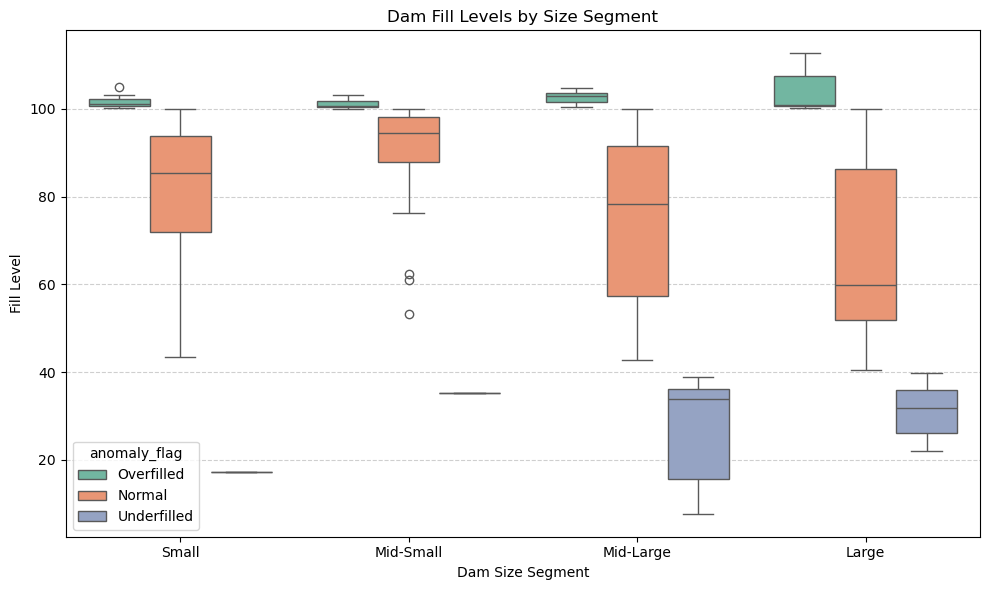

In [20]:
import seaborn as sns

# Define thresholds
underfilled_threshold = 40  # % full
overfilled_threshold = 100  # % full

# Flag anomalies
df_combined['anomaly_flag'] = df_combined['percentage_full'].apply(
    lambda x: 'Underfilled' if x < underfilled_threshold else
              'Overfilled' if x > overfilled_threshold else
              'Normal'
)


# Create size segments
df_combined['size_segment'] = pd.qcut(df_combined['full_volume'], q=4, labels=['Small', 'Mid-Small', 'Mid-Large', 'Large'])

# Grouped boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x='size_segment', y='percentage_full', hue='anomaly_flag', palette='Set2')

plt.title('Dam Fill Levels by Size Segment')
plt.ylabel('Fill Level')
plt.xlabel('Dam Size Segment')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- Dams are grouped into four size segments: Small, Mid-Small, Mid-Large, and Large
- Each segment includes three anomaly categories: Overfilled (< 100%), Normal (40% - 100%), and Underfilled (> 40%)
- Overfilled dams show consistently high median fill levels across all size segments, especially in Small and Mid-Small groups
- Normal dams maintain moderate fill levels with relatively narrow interquartile ranges, indicating stable performance
- Underfill conditions are more common in larger dams, whereas smaller dams tend to exceed their capacity more frequently

In [21]:
import numpy as np

# Sydney coordinates
sydney_lat = -33.8688
sydney_lon = 151.2093

# Convert degrees to radians
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Apply to dataframe
df_combined['distance_to_sydney_km'] = df_combined.apply(
    lambda row: haversine(row['lat'], row['long'], sydney_lat, sydney_lon),
    axis=1
)

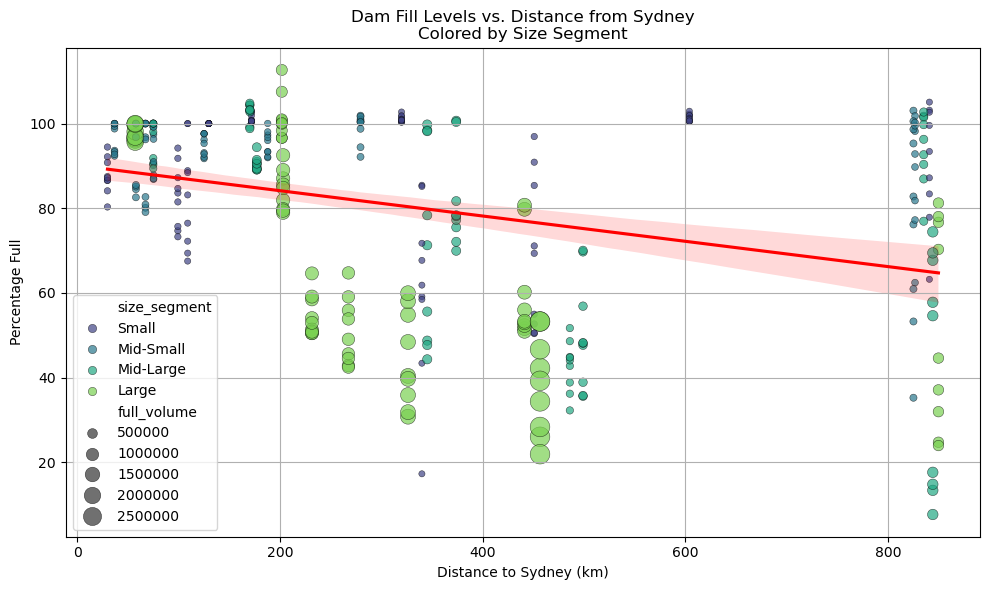

In [22]:
# Create size segments
df_combined['size_segment'] = pd.qcut(df_combined['full_volume'], q=4, labels=['Small', 'Mid-Small', 'Mid-Large', 'Large'])

# Set up the figure
plt.figure(figsize=(10, 6))

# Scatter plot with color by size and size by volume
sns.scatterplot(
    data=df_combined,
    x='distance_to_sydney_km',
    y='percentage_full',
    hue='size_segment',
    palette='viridis',
    size='full_volume',
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='k'
)

# Add trend line (without linestyle)
sns.regplot(
    data=df_combined,
    x='distance_to_sydney_km',
    y='percentage_full',
    scatter=False,
    color='red'
)

# Adding Title / Labels / Legend
plt.title('Dam Fill Levels vs. Distance from Sydney\nColored by Size Segment')
plt.xlabel('Distance to Sydney (km)')
plt.ylabel('Percentage Full')
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

- Each point represents a dam, plotted by its distance from Sydney and fill level.
- Marker size reflects dam volume; color indicates size segment (Small to Large).
- Approximately 78% of dams fall within a distance of 600km and 22% outside of that.
- Fill levels generally decline as distance from Sydney increases.
- Larger dams are more prevalent between the 200 - 600 km range but tend to show lower fill percentages.
- A downward trend line shows a negative correlation between distance and dam fill levels

## **Conclusion**
This analysis set out to answer three questions:
Where are NSW’s dams located? What metrics define their performance? And how are they tracking over time?
- The analysis highlights distinct geographic and operational trends that could be used to inform infrastructure priorities, risk mitigation, and resource strategies.

**Location - Urban Advantage vs. Remote Vulnerability**
- Dams near Sydney show higher fill levels and greater stability, likely due to better infrastructure, prioritization, and rainfall.
- Remote dams exhibit greater variability and underfilling, pointing to environmental and logistical challenges.

**Operational Signals**
- Approximately 42% of dams are at or above capacity, indicating overspill risk.
- Smaller dams tend to be consistently full, while larger dams show high inflow but lower release, suggesting use as buffers or flood mitigation assets.
- Underfilling, overfilling, zero inflow/release in half the dataset, and negative inflow values, all pointing to skewed utilisation, stagnant flow and potential data quality issues.

**Strategic Takeaways**
- Size and location matter: Smaller, remote dams may need support; larger dams require spill monitoring.
- Operational anomalies are patterned — not random — and can guide inspection and resource allocation.
- Urban proximity correlates with performance resilience, offering a lens for future infrastructure investment.

**Recommendations**
- Flag underfilled small dams for inspection.
- Monitor overfilled large dams for flood risk.
- Segment strategies by dam size and location.
- Integrate climate data for predictive modeling.
- Build interactive dashboards for stakeholder engagement.